In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3

from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.config import INDICATORS, TRAINED_MODEL_DIR
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split

%matplotlib inline

In [2]:
trade = pd.read_csv('trade_data.csv')
trade = trade.set_index(trade.columns[0])
trade.index.names = ['']

In [3]:
trade=data_split(trade, '2023-01-01', '2024-01-01')
trade.head()

,date,tic,open,high,low,close,volume,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
0,2023-01-03,AAPL,130.279999,130.899994,124.169998,123.904625,112117500.0,1.0,-4.664941,148.380015,121.517494,39.011489,-130.926001,35.987249,138.780054,141.061399,22.9,58.114417
0,2023-01-03,ADBE,340.160004,345.820007,331.920013,336.920013,2229100.0,1.0,2.018147,344.361914,325.710086,51.312759,55.832999,17.420819,334.678332,321.834165,22.9,58.114417
0,2023-01-03,ADI,165.570007,166.199997,161.440002,157.418777,4475700.0,1.0,0.279274,168.515870,154.019671,51.525939,-68.722035,8.072027,161.102222,151.353293,22.9,58.114417
0,2023-01-03,ADP,240.789993,241.509995,235.270004,228.564453,1749800.0,1.0,-3.817562,258.519213,221.412165,45.483461,-115.839651,14.036269,243.547140,235.814659,22.9,58.114417
0,2023-01-03,ADSK,190.619995,192.960007,183.000000,185.149994,1181600.0,1.0,-4.526453,203.341768,180.661229,44.659114,-94.290116,3.860456,195.468332,200.417166,22.9,58.114417


In [4]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2 * stock_dimension + len(INDICATORS) * stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

Stock Dimension: 68, State Space: 681


In [5]:
trained_a2c = A2C.load(TRAINED_MODEL_DIR + "/agent_a2c")
trained_ddpg = DDPG.load(TRAINED_MODEL_DIR + "/agent_ddpg")
trained_ppo = PPO.load(TRAINED_MODEL_DIR + "/agent_ppo")
trained_td3 = TD3.load(TRAINED_MODEL_DIR + "/agent_td3")
trained_sac = SAC.load(TRAINED_MODEL_DIR + "/agent_sac")

In [6]:
def DRL_ensemble_prediction(environment, a2c_model=None, ddpg_model=None, ppo_model=None, td3_model=None, sac_model=None, weights=[1,1,1,1,1], deterministic=True):
    test_env, test_obs = environment.get_sb_env()
    account_memory = None
    actions_memory = None


    test_env.reset()
    max_steps = len(environment.df.index.unique()) - 1

    print(max_steps)

    _weights = []
    if a2c_model is not None:
        _weights.append(weights[0])
    if ddpg_model is not None:
        _weights.append(weights[1])
    if ppo_model is not None:
        _weights.append(weights[2])
    if td3_model is not None:
        _weights.append(weights[3])
    if sac_model is not None:
        _weights.append(weights[4])
    
    weights = np.array(_weights)
    

    for i in tqdm(range(len(environment.df.index.unique()))):
        if a2c_model is not None:
            a2c_action, _states = a2c_model.predict(test_obs, deterministic=deterministic)
        if ddpg_model is not None:
            ddpg_action, _states = ddpg_model.predict(test_obs, deterministic=deterministic)
        if ppo_model is not None:
            ppo_action, _states = ppo_model.predict(test_obs, deterministic=deterministic)
        if td3_model is not None:
            td3_action, _states = td3_model.predict(test_obs, deterministic=deterministic)
        if sac_model is not None:
           sac_action, _states = sac_model.predict(test_obs, deterministic=deterministic)
        

        actions = []
        action_length = 0

        if a2c_model is not None and len(a2c_action) > 0:
            action_length = len(a2c_action[0])
        elif ddpg_model is not None and len(ddpg_action) > 0:
            action_length = len(ddpg_action[0])
        elif ppo_model is not None and len(ppo_action) > 0:
            action_length = len(ppo_action[0])
        elif td3_model is not None and len(td3_action) > 0:
            action_length = len(td3_action[0])
        elif sac_model is not None and len(sac_action) > 0:
            action_length = len(sac_action[0])

        for j in range(action_length):
            _actions = []
            if a2c_model is not None:
                # print(a2c_action)
                _actions.append(a2c_action[0][j])
            if ddpg_model is not None:
                _actions.append(ddpg_action[0][j])
            if ppo_model is not None:
                _actions.append(ppo_action[0][j])
            if td3_model is not None:
                _actions.append(td3_action[0][j])
            if sac_model is not None:
                _actions.append(sac_action[0][j])
            _action = np.sum(_actions * weights) / np.sum(weights)
            actions.append(_action)
        actions[0] = np.array(actions)

        test_obs, rewards, dones, info = test_env.step(actions)  

        if (i == max_steps - 1):  
            account_memory = test_env.env_method(method_name="save_asset_memory")
            actions_memory = test_env.env_method(method_name="save_action_memory")



        if dones[0]:  
            print("hit end!")
            break

    return account_memory[0], actions_memory[0]  

In [7]:
df_account_value_merge, df_actions_merge = DRL_ensemble_prediction(
    a2c_model=trained_a2c, 
    ddpg_model=trained_ddpg,
    ppo_model=trained_ppo,
    td3_model=trained_td3,
    sac_model=trained_sac,
    weights=[1, 2, 3, 4, 5],
    environment = e_trade_gym)

248


100%|█████████▉| 248/249 [00:01<00:00, 172.23it/s]

hit end!


In [8]:
df_account_value_merge.tail(10)

,date,account_value
239,2023-12-14,1.336939e+06
240,2023-12-15,1.343660e+06
241,2023-12-18,1.344525e+06
242,2023-12-19,1.355349e+06
243,2023-12-20,1.334816e+06
244,2023-12-21,1.349302e+06
245,2023-12-22,1.354918e+06
246,2023-12-26,1.363353e+06
247,2023-12-27,1.363219e+06
248,2023-12-28,1.367380e+06


In [9]:
test_env, test_obs = e_trade_gym.get_sb_env()
a2c_action, _states = trained_a2c.predict(test_obs, deterministic=True)

In [10]:
a2c_action

array([[ 1.        ,  1.        ,  1.        ,  1.        , -1.        ,
        -1.        ,  1.        , -0.65387243,  1.        , -1.        ,
         1.        ,  1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        ,  1.        ,  0.569773  ,
         0.45166317,  1.        , -1.        , -0.52100146, -1.        ,
         1.        , -1.        , -1.        ,  0.16547962, -1.        ,
        -1.        ,  1.        , -0.34704542,  0.02504051, -1.        ,
        -0.3966578 ,  1.        ,  0.14025176,  0.02251373,  1.        ,
         0.49129128,  0.20406397, -1.        , -0.596449  , -1.        ,
         0.24977826,  0.83777153,  1.        , -1.        , -1.        ,
        -1.        , -1.        ,  1.        ,  1.        , -1.        ,
        -1.        ,  0.17500924,  1.        , -0.01665697,  1.        ,
        -1.        , -1.        , -0.36138016,  1.        , -1.        ,
        -1.        ,  1.        , -1.        ]], dt

In [11]:
trade['tic'].unique()

array(['AAPL', 'ADBE', 'ADI', 'ADP', 'ADSK', 'ALGN', 'AMAT', 'AMD',
       'AMGN', 'AMZN', 'ASML', 'BIIB', 'BKNG', 'BMRN', 'CDNS', 'CHKP',
       'CMCSA', 'COST', 'CSCO', 'CSX', 'CTAS', 'CTSH', 'DLTR', 'EA',
       'EBAY', 'FAST', 'GILD', 'HAS', 'HSIC', 'IDXX', 'ILMN', 'INCY',
       'INTC', 'INTU', 'ISRG', 'JBHT', 'KLAC', 'LRCX', 'MAR', 'MCHP',
       'MDLZ', 'MNST', 'MSFT', 'MU', 'NFLX', 'NTAP', 'NTES', 'NVDA',
       'ORLY', 'PAYX', 'PCAR', 'PEP', 'QCOM', 'REGN', 'ROST', 'SBUX',
       'SIRI', 'SNPS', 'SWKS', 'TCOM', 'TTWO', 'TXN', 'VRSN', 'VRTX',
       'WBA', 'WDC', 'WYNN', 'XEL'], dtype=object)

# DJI index

In [12]:
TRADE_START_DATE = df_account_value_merge['date'].unique().tolist()[0]
TRADE_END_DATE = df_account_value_merge['date'].unique().tolist()[-1]

In [13]:
df_dji = YahooDownloader(
    start_date=TRADE_START_DATE, end_date=TRADE_END_DATE, ticker_list=["^DJI"]
).fetch_data()

100%|██████████| 1/1 [00:01<00:00,  1.79s/it]

Shape of DataFrame:  (248, 8)


In [14]:
df_dji = df_dji[["date", "close"]]
fst_day = df_dji["close"][0]
dji = pd.merge(
    df_dji["date"],
    df_dji["close"].div(fst_day).mul(1000000),
    how="outer",
    left_index=True,
    right_index=True,
).set_index("date")

In [15]:
df_result_merge = (df_account_value_merge.set_index(df_account_value_merge.columns[0]))

result = pd.DataFrame(
    {
        "merge strategy": df_result_merge["account_value"],
        # "mvo": MVO_result["Mean Var"],
        "dji": dji["close"],
    }
)

<Figure size 12000x4000 with 0 Axes>

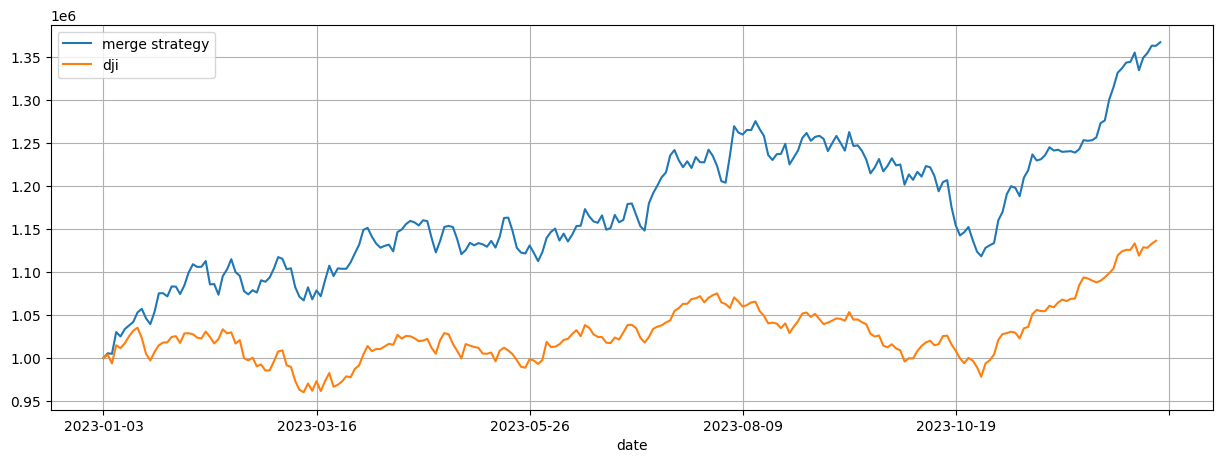

In [16]:
plt.rcParams["figure.figsize"] = (15,5)
plt.figure(dpi=800)
result.plot()
plt.grid(True)
plt.show()

# Calculate Indicators

In [17]:
def calculate_rolling_sharpe(account_value, DJI_value, window=252):
    if len(account_value) != len(DJI_value):
        raise ValueError("The length of account_value and DJI_value must be the same.")
    
    # Convert account and DJI values to returns
    account_returns = np.diff(account_value) / account_value[:-1]
    DJI_returns = np.diff(DJI_value) / DJI_value[:-1]

    # Rolling Sharpe Ratio calculation
    sharpe_ratios = []
    for i in range(window+1):
        sharpe_ratios.append(0)
    for i in range(window, len(account_returns)):
        account_slice = account_returns[i-window:i]
        DJI_slice = DJI_returns[i-window:i]

        # Excess returns (difference between account and DJI)
        excess_returns = account_slice - DJI_slice

        # Calculate Sharpe Ratio: (mean of excess returns) / (std of excess returns)
        sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns, ddof=1)
        sharpe_ratios.append(sharpe_ratio)
    
    return sharpe_ratios

# Function to calculate Alpha
def calculate_alpha(account_value, DJI_value, risk_free_rate=0.01, window=252):
    if len(account_value) != len(DJI_value):
        raise ValueError("The length of account_value and DJI_value must be the same.")
    
    account_returns = np.diff(account_value) / account_value[:-1]
    DJI_returns = np.diff(DJI_value) / DJI_value[:-1]

    alphas = []
    for i in range(window+1):
        alphas.append(0)
    for i in range(window, len(account_returns)):
        account_slice = account_returns[i-window:i]
        DJI_slice = DJI_returns[i-window:i]
        
        # Calculate excess returns for both the account and DJI relative to risk-free rate
        excess_account = account_slice - risk_free_rate / 252
        excess_DJI = DJI_slice - risk_free_rate / 252
        
        # Alpha = (Mean of account returns - risk-free rate) - Beta * (Mean of DJI returns - risk-free rate)
        cov = np.cov(excess_account, excess_DJI)[0, 1]
        var = np.var(excess_DJI)
        beta = cov / var
        alpha = np.mean(excess_account) - beta * np.mean(excess_DJI)
        alphas.append(alpha)
    
    return alphas

# Function to calculate Beta
def calculate_beta(account_value, DJI_value, window=252):
    if len(account_value) != len(DJI_value):
        raise ValueError("The length of account_value and DJI_value must be the same.")
    
    account_returns = np.diff(account_value) / account_value[:-1]
    DJI_returns = np.diff(DJI_value) / DJI_value[:-1]

    betas = []
    for i in range(window+1):
        betas.append(0)
    for i in range(window, len(account_returns)):
        account_slice = account_returns[i-window:i]
        DJI_slice = DJI_returns[i-window:i]
        
        # Beta = Cov(account, DJI) / Var(DJI)
        cov = np.cov(account_slice, DJI_slice)[0, 1]
        var = np.var(DJI_slice)
        beta = cov / var
        betas.append(beta)
    
    return betas

# Function to calculate Sortino Ratio
def calculate_sortino_ratio(account_value, DJI_value, window=252, risk_free_rate=0.01):
    if len(account_value) != len(DJI_value):
        raise ValueError("The length of account_value and DJI_value must be the same.")
    
    account_returns = np.diff(account_value) / account_value[:-1]
    DJI_returns = np.diff(DJI_value) / DJI_value[:-1]

    sortino_ratios = []
    for i in range(window+1):
        sortino_ratios.append(0)
    for i in range(window, len(account_returns)):
        account_slice = account_returns[i-window:i]
        DJI_slice = DJI_returns[i-window:i]
        
        # Excess returns (difference between account and DJI returns)
        excess_returns = account_slice - DJI_slice
        downside_deviation = np.std([x for x in excess_returns if x < 0], ddof=1)

        # Sortino Ratio = Mean of excess returns / Downside deviation
        sortino_ratio = np.mean(excess_returns) / downside_deviation if downside_deviation != 0 else np.nan
        sortino_ratios.append(sortino_ratio)
    
    return sortino_ratios

# Function to calculate Volatility
def calculate_volatility(account_value, window=252):
    account_returns = np.diff(account_value) / account_value[:-1]
    
    volatilities = []
    for i in range(window+1):
        volatilities.append(0)
    for i in range(window, len(account_returns)):
        account_slice = account_returns[i-window:i]
        
        # Volatility = Standard deviation of returns
        volatility = np.std(account_slice, ddof=1)
        volatilities.append(volatility)
    
    return volatilities

account_value = df_account_value_merge['account_value'].tolist()[0:-1]
dji_value = dji['close'].tolist()

sharpe_ratio = calculate_rolling_sharpe(account_value, dji_value)
# print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
# print(calculate_rolling_sharpe(account_value, dji_value))

In [18]:
account_value = df_account_value_merge['account_value'].tolist()[0:-1]
dji_value = df_dji['close'].tolist()

window = 30

sharpe_ratio = calculate_rolling_sharpe(account_value, dji_value, window=window)
alpha = calculate_alpha(account_value, dji_value, window=window)
beta = calculate_beta(account_value, dji_value, window=window)
sortino_ratio = calculate_sortino_ratio(account_value, dji_value, window=window)
volatility = calculate_volatility(account_value, window=window)

In [19]:
result2 = pd.DataFrame(
    {
        "Sharpe Ratio": sharpe_ratio,
        "Beta": beta,
        "alpha": alpha,
        "Sortino Ratio": sortino_ratio,
        "Volatility": volatility,
    }
)

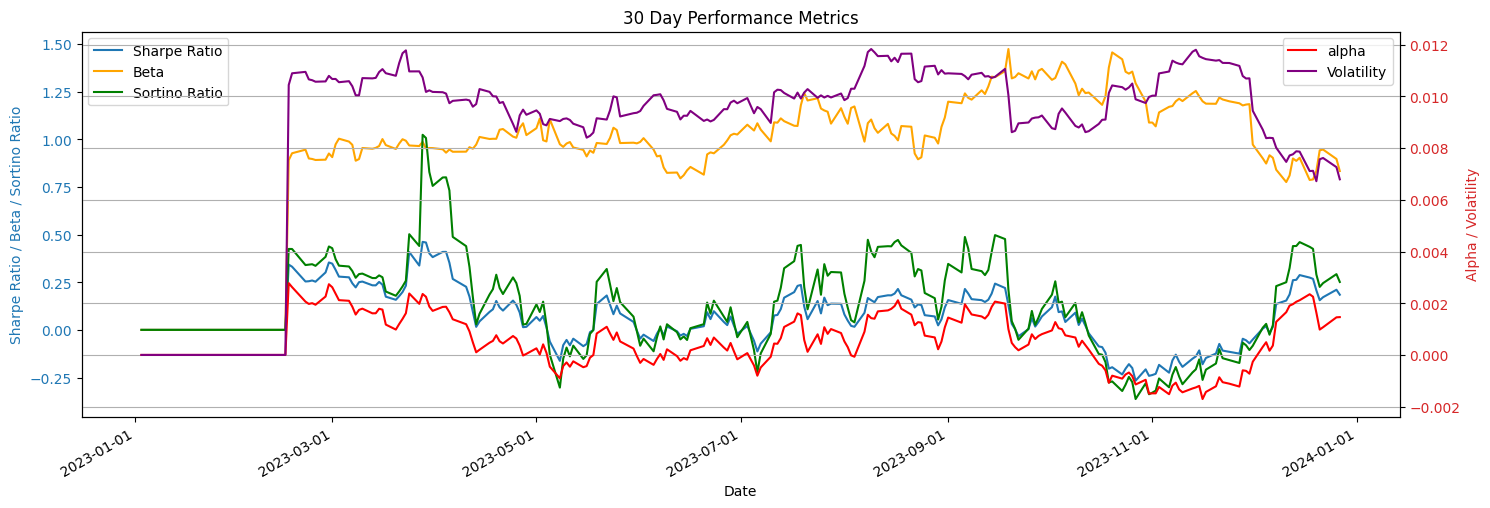

In [20]:
import matplotlib.dates as mdates

plt.rcParams["figure.figsize"] = (15, 5)

dates = pd.to_datetime(df_dji['date'])

fig, ax1 = plt.subplots()

ax1.set_xlabel('Date')
ax1.set_ylabel('Sharpe Ratio / Beta / Sortino Ratio', color='tab:blue')
ax1.plot(dates, result2['Sharpe Ratio'], label='Sharpe Ratio', color='tab:blue')
ax1.plot(dates, result2['Beta'], label='Beta', color='orange')
ax1.plot(dates, result2['Sortino Ratio'], label='Sortino Ratio', color='green')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Alpha / Volatility', color='tab:red')
ax2.plot(dates, result2['alpha'], label='alpha', color='red')
ax2.plot(dates, result2['Volatility'], label='Volatility', color='purple')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

fig.autofmt_xdate()

# 显示网格线和图形
plt.title('{} Day Performance Metrics'.format(window))
plt.grid(True)
plt.show()
